In [33]:
import helpfunction as helper
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LogNorm

In [34]:
fidvol_vtx = [10, 10, 10, 10, 10, 50]
mass_mu = 0.106
mass_p = 0.938272
kin_min = 0.04
kin_min_mu = kin_min + mass_mu

gr = (1 + 5 ** 0.5) / 2


In [35]:
d = {}

samples = {
    #'nu': './input/run1/nu_run1.root'
    'nu': '~/NuCCanalyser/NuCC_overlay.root'
}
main_tree_name = "NuCCanalyzer"

for sample, filename in samples.items():
    file = uproot.open(filename)[main_tree_name]
    d[sample] = {
        "subruns": file["subruns"],
        "events": file["Event"],
        "daughters": file["Daughters"],
    }

    all_events = d[sample]["events"].numentries
    sel_events = sum(d[sample]["events"].array("nu_mu_cc_selected"))
    print(sample + ":All events: ", all_events, "")
    print(
        "Selected events: ",
        sel_events,
        "({:.02f}%)".format(sel_events / all_events * 100),
    )

    d[sample]["event_hash"] = helper.eventHash(
        d[sample]["events"].pandas.df(["evt_time_sec", "evt_time_nsec"])
    )
    d[sample]["forbidden_hashes"] = d[sample]["event_hash"][
        d[sample]["event_hash"].duplicated()
    ]
    print("\tDuplicated:", len(d[sample]["forbidden_hashes"]))

    d[sample]["df_daughters"] = d[sample]["daughters"].pandas.df(flatten=False)
    d[sample]["df_daughters"]["hash"] = helper.eventHash(
        d[sample]["df_daughters"][["evt_time_sec", "evt_time_nsec"]]
    )
    d[sample]["df_daughters"]["duplicated"] = d[sample]["df_daughters"]["hash"].isin(
        d[sample]["forbidden_hashes"]
    )
    d[sample]["df_daughters"] = (
        d[sample]["df_daughters"].query("~duplicated").copy().reset_index(drop=True)
    )

('nu:All events: ', 1045525, '')
('Selected events: ', 153957, '(0.00%)')
('\tDuplicated:', 0)


In [36]:
# Add the signal categories, only needed for the nu sample:
cols = [
    "mc_nu_ccnc",
    "mc_nu_lepton_energy",
    "mc_nu_pdg",
    "mc_nu_vx",
    "mc_nu_vy",
    "mc_nu_vz",
]

df_nu_event = d["nu"]["events"].pandas.df(cols)

nu_tpc_mask = helper.inTPC_mask(df_nu_event, "mc_nu_vx", "mc_nu_vy", "mc_nu_vz")

nu_fid_vol_mask = helper.inTPC_mask(
    df_nu_event, "mc_nu_vx", "mc_nu_vy", "mc_nu_vz", fidvol=fidvol_vtx
)

sig_def_ccinc = "abs(mc_nu_pdg)==14 & mc_nu_ccnc==0 & mc_nu_lepton_energy>@kin_min_mu"
sig_mask_ccinc = df_nu_event.eval(sig_def_ccinc) & nu_fid_vol_mask

# Has the event one pi0
pi0_index = d["nu"]["events"].array("mc_nu_daughter_pdg") == 111
sig_mask_pi0 = sig_mask_ccinc & (pi0_index.sum() == 1)

# Has x protons
sig_masks_proton = []
m1 = d["nu"]["events"].array("mc_nu_daughter_pdg") == 2212
m2 = d["nu"]["events"].array("mc_nu_daughter_energy") > mass_p + kin_min
proton_index = m1 & m2
sig_masks_proton = [
    sig_mask_ccinc & (proton_index.sum() == x_proton) for x_proton in range(4)
]


# Add MC info
mapper = dict(zip(d["nu"]["event_hash"], nu_tpc_mask))
d["nu"]["df_daughters"]["mc_nu_in_tpc"] = d["nu"]["df_daughters"]["hash"].map(mapper)
mapper = dict(zip(d["nu"]["event_hash"], nu_fid_vol_mask))
d["nu"]["df_daughters"]["mc_nu_fid_vol"] = d["nu"]["df_daughters"]["hash"].map(mapper)

mapper = dict(zip(d["nu"]["event_hash"], sig_mask_ccinc))
d["nu"]["df_daughters"]["mc_sig_nuccinc"] = d["nu"]["df_daughters"]["hash"].map(mapper)
mapper = dict(zip(d["nu"]["event_hash"], sig_mask_pi0))
d["nu"]["df_daughters"]["mc_sig_nuccpi0"] = d["nu"]["df_daughters"]["hash"].map(mapper)

In [37]:
pot_on = 1.467e20
triggers_on = 35425849
triggers_off = 31725245

samples_mc = ["nue", "nu", "dirt"]
for smc in samples_mc:
    if smc in samples:
        pot = sum(d[smc]["subruns"].array("pot"))
        pot_corr = pot * (
            1 - len(d[smc]["forbidden_hashes"]) * 2 / d[smc]["events"].numentries
        )
        d[smc]["scale"] = pot_on / pot_corr
        print(smc, ":\t", pot_corr)

('nu', ':\t', 1.3081447199159453e+21)


In [38]:
mapper_list = [
    "mc_nu_energy",
    "mc_nu_pdg",
    "mc_nu_ccnc",
    "mc_nu_lepton_theta",
    "mc_nu_vtx_distance",
    "clustered_hit_completeness",
    "matched_hit_fraction",
]

for smc in samples_mc:
    if smc in samples:
        print(smc)
        for field in mapper_list:
            mapper = dict(zip(d[smc]["event_hash"], d[smc]["events"].array(field)))
            d[smc]["df_daughters"][field] = d[smc]["df_daughters"]["hash"].map(mapper)

nu


In [39]:
mapper_list = [
    "nu_pdg",
    "num_tracks",
    "num_showers",
    "obvious_cosmic_chi2",
    "nu_flash_chi2",
    "nu_score",
    "nu_contained",
    "daughters_start_contained",
    "event_weight",
]

for sample in samples:
    print(sample)
    for field in mapper_list:
        mapper = dict(zip(d[sample]["event_hash"], d[sample]["events"].array(field)))
        d[sample]["df_daughters"][field] = d[sample]["df_daughters"]["hash"].map(mapper)

        d[sample]["df_daughters"][["theta_beam", "phi_beam"]] = helper.cosmic_angles(
            *d[sample]["df_daughters"][
                ["track_dirx", "track_diry", "track_dirz"]
            ].T.values
        )

        end_mask = helper.inTPC_mask(
            d[sample]["df_daughters"],
            "track_endx",
            "track_endy",
            "track_endz",
            [10] * 6,
        )
        d[sample]["df_daughters"]["contained"] = (
            d[sample]["df_daughters"]["start_contained"] & end_mask
        )

nu


In [40]:
for sample in samples:
    # Tag the muon candidate
    d[sample]["df_daughters"]["muon_candidate"] = d[sample]["df_daughters"].eval(
        muon_candidate_selection
    )
    d[sample]["df_daughters"].loc[
        d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
    ] = (
        d[sample]["df_daughters"]
        .query("muon_candidate")
        .groupby(["hash"])["track_length"]
        .transform(max)
    )
    d[sample]["df_daughters"].loc[
        ~d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
    ] = -1

    d[sample]["df_daughters"]["chi2_ratio"] = d[sample]["df_daughters"].eval(
        "track_chi2_proton/track_chi2_muon"
    )
    d[sample]["df_daughters"].loc[
        d[sample]["df_daughters"]["muon_candidate"], "highest_chi2_ratio"
    ] = (
        d[sample]["df_daughters"]
        .query("muon_candidate")
        .groupby(["hash"])["chi2_ratio"]
        .transform(max)
    )
    d[sample]["df_daughters"].loc[
        ~d[sample]["df_daughters"]["muon_candidate"], "highest_chi2_ratio"
    ] = -1

    # Tag the event selection
    d[sample]["df_daughters"]["python_select"] = d[sample]["df_daughters"].eval(
        query_select
    )

In [41]:
muon_candidate_selection = "track_score>0.90 &\
                            vtx_distance<4.0 &\
                            track_chi2_proton>60.0 &\
                            track_chi2_muon<30.0 &\
                            (track_chi2_proton/track_chi2_muon)>7.0 &\
                            generation==2 &\
                            track_length>5"
event_selection = "mc_nu_pdg==14 &\
                   (nu_flash_chi2<10.0 | nu_score>0.25) &\
                   daughters_start_contained &\
                   nu_contained &\
                   longest_muon_candidate_length==track_length &\
                   nu_score>0.06"
# Selection queries
query_select_wo_trackcut = event_selection
query_select = query_select_wo_trackcut + " & track_length>20.0"
query_pure = "mc_nu_vtx_distance<5 & abs(mc_pdg)==13"
query_event = query_select + " & " + query_pure

d["nu"]["df_daughters"].query(query_event)["nu_score"],
d["nu"]["df_daughters"].query(query_event)["nu_flash_chi2"],

(13           0.979370
 16           6.389270
 24          47.107803
 41           3.598572
 47           1.145936
 55           7.546242
 69           0.766939
 70           1.653346
 91           1.773566
 93           1.258787
 98           8.529840
 115          3.104046
 128        119.521278
 130          4.874032
 131          0.896166
 136          4.994493
 143         28.938185
 153         70.679695
 161          1.642983
 186          1.475612
 196          1.653954
 205         14.037934
 229          4.102750
 239          2.219310
 259        139.378143
 263          6.928604
 269          0.989128
 273         86.554428
 276        145.814728
 280          0.937864
               ...    
 1083507      1.342923
 1083509      2.474099
 1083519     44.105846
 1083530      0.651141
 1083545      4.142364
 1083560      0.685092
 1083596      7.075412
 1083608      5.224916
 1083620      0.871695
 1083621      3.165630
 1083624     13.887435
 1083643      3.704027
 1083656   

In [42]:
# Selection queries
query_select_wo_trackcut = event_selection
query_select = query_select_wo_trackcut + " & track_length>20.0"
query_pure = "mc_nu_vtx_distance<5 & abs(mc_pdg)==13"
query_event = query_select + " & " + query_pure

In [43]:
# Using python:
num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccinc")["python_select"].sum()
num_denom = sum(sig_mask_ccinc)
error = helper.effErr(num_sel, num_denom)
print(
    "Muon neutrino CC inc selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)

num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccpi0")["python_select"].sum()
num_denom = sum(sig_mask_pi0)
error = helper.effErr(num_sel, num_denom)
print(
    "Muon neutrino CC pi0 selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)

# purity
purity_nom = (
    d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_select).sum()
    * d["nu"]["scale"]
)
purity_nom_plus = (
    d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_event).sum()
    * d["nu"]["scale"]
)
purity_denom = 0

for s in ['nu']: #"off", "nu"]: #, "dirt"]:
    purity_denom += d[s]["df_daughters"]["python_select"].sum() * d[s]["scale"]

error = helper.effErr(purity_nom, purity_denom)
purity = purity_nom / purity_denom
print(
    "Muon neutrino CC inc selection purity (basic): ({0:0.2f}+-{1:0.2f})%".format(
        purity * 100, error * 100
    )
)
error = helper.effErr(purity_nom_plus, purity_denom)
purity_plus = purity_nom_plus / purity_denom
print(
    "Muon neutrino CC inc selection purity (strict): ({0:0.2f}+-{1:0.2f})%".format(
        purity_plus * 100, error * 100
    )
)

Muon neutrino CC inc selection efficiency: (0.00+-0.14)%
Muon neutrino CC pi0 selection efficiency: (0.00+-0.40)%
Muon neutrino CC inc selection purity (basic): (87.14+-0.26)%
Muon neutrino CC inc selection purity (strict): (73.65+-0.34)%


0.7512634439111017


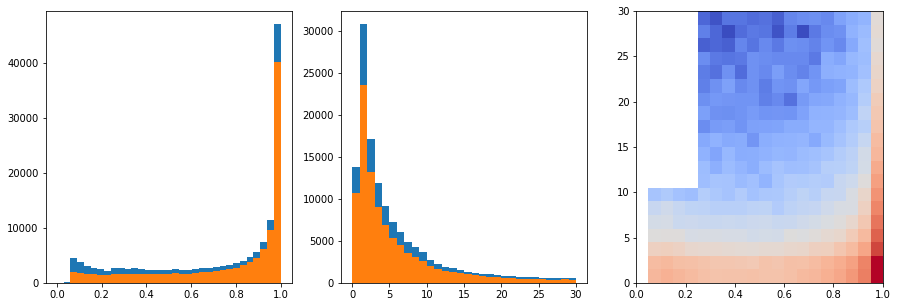

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

hist1, _, _ = ax1.hist(d["nu"]["df_daughters"].query(query_select)["nu_score"], bins=np.linspace(0, 1, 34))
hist2, _, _ = ax1.hist(d["nu"]["df_daughters"].query(query_event)["nu_score"], bins=np.linspace(0, 1, 34))
print(np.sum(hist2)/np.sum(hist1))

ax2.hist(d["nu"]["df_daughters"].query(query_select)["nu_flash_chi2"], bins=np.linspace(0, 30, 31))
ax2.hist(d["nu"]["df_daughters"].query(query_event)["nu_flash_chi2"], bins=np.linspace(0, 30, 31))

ax3.hist2d(
    d["nu"]["df_daughters"].query(query_event)["nu_score"],
    d["nu"]["df_daughters"].query(query_event)["nu_flash_chi2"],
    cmap="coolwarm",
    range=[[0, 1], [0, 30]],
    bins=[20, 20],
    norm=LogNorm(),
)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

hist1, _, _ = ax1.hist(d["nu"]["df_daughters"].query(query_select)["nu_score"], bins=np.linspace(0, 1, 34))
hist2, _, _ = ax1.hist(d["nu"]["df_daughters"].query(query_event)["nu_score"], bins=np.linspace(0, 1, 34))
print(np.sum(hist2)/np.sum(hist1))

ax2.hist(d["nu"]["df_daughters"].query(query_select)["nu_flash_chi2"], bins=np.linspace(0, 30, 31))
ax2.hist(d["nu"]["df_daughters"].query(query_event)["nu_flash_chi2"], bins=np.linspace(0, 30, 31))

ax3.hist2d(
    d["nu"]["df_daughters"].query(query_event)["nu_score"],
    d["nu"]["df_daughters"].query(query_event)["nu_flash_chi2"],
    cmap="coolwarm",
    range=[[0, 1], [0, 30]],
    bins=[20, 20],
    norm=LogNorm(),
)
plt.show()